# AML Data Preprocessing
- Using the IBM dataset for AML: https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml
- Dataset is generated by IBM Box Generator, models transactions and illicit activities.
- Original dataset for training will be extensively large, for initial stages of thesis, using smaller dataset of 500,000 transactions.
- In the following we will:
1. explore the data
2. determine nodes and edges
3. determine node and edge attributes
4. create visualization using NetworkX, PyVis, or Graph-tool

* Attributes on ACCOUNT
    * Bank account
    * Account balance
    * BIN number
    * Number of transactions (calculated)
    * Receiving Currency
* Attributes on TRANSACTIONS
    * Payment amount
    * Payment Type
    * Payment Currency (based on “receiving currency” of outgoing bank account)
    * Time


##### *-----IMPORT LIBRARIES-----*

In [ ]:
! pip3 install torch numpy pandas matplotlib torch-geometric

In [55]:
import torch
import time
import random
import hashlib
import datetime
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from pandas import Timestamp
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

##### *-----DATA EXPLORATION-----*

In [2]:
filename = "/Users/owhy/Documents/Datasets/HI-Small_Trans.csv"

In [3]:
data = pd.read_csv(filename)
data.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [4]:
print(f"---- shape ----\n - {data.shape}")

---- shape ----
 - (5078345, 11)


In [5]:
print("---- info ----")
data.info()

---- info ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [6]:
print("---- basic calculations ----")
data.describe()

---- basic calculations ----


,From Bank,To Bank,Amount Received,Amount Paid,Is Laundering
count,5.078345e+06,5.078345e+06,5.078345e+06,5.078345e+06,5.078345e+06
mean,4.573057e+04,6.574456e+04,5.988726e+06,4.509273e+06,1.019427e-03
std,8.176562e+04,8.409299e+04,1.037183e+09,8.697728e+08,3.191219e-02
min,1.000000e+00,1.000000e+00,1.000000e-06,1.000000e-06,0.000000e+00
25%,1.190000e+02,4.259000e+03,1.833700e+02,1.844800e+02,0.000000e+00
50%,9.679000e+03,2.156800e+04,1.411010e+03,1.414540e+03,0.000000e+00
75%,2.862800e+04,1.223320e+05,1.234627e+04,1.229784e+04,0.000000e+00
max,3.563030e+05,3.562940e+05,1.046302e+12,1.046302e+12,1.000000e+00


##### *-----Creating Graph-----*

### NODES and EDGES

Nodes = Bank Accounts -- bank account number
* BIN Number
* Receiving Currency

* Number of transactions (degree matrix --> calculated based on incoming and outcoming flows)

Edges = transactions -- payment amount
* Payment Type
* Payment Currency
* Date and Time

* Account Balance (before transactions)

In [7]:
data

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.340000,US Dollar,3697.340000,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.010000,US Dollar,0.010000,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.570000,US Dollar,14675.570000,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.970000,US Dollar,2806.970000,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.970000,US Dollar,36682.970000,US Dollar,Reinvestment,0
...,...,...,...,...,...,...,...,...,...,...,...
5078340,2022/09/10 23:57,54219,8148A6631,256398,8148A8711,0.154978,Bitcoin,0.154978,Bitcoin,Bitcoin,0
5078341,2022/09/10 23:35,15,8148A8671,256398,8148A8711,0.108128,Bitcoin,0.108128,Bitcoin,Bitcoin,0
5078342,2022/09/10 23:52,154365,8148A6771,256398,8148A8711,0.004988,Bitcoin,0.004988,Bitcoin,Bitcoin,0
5078343,2022/09/10 23:46,256398,8148A6311,256398,8148A8711,0.038417,Bitcoin,0.038417,Bitcoin,Bitcoin,0


In [8]:
# list of unique bank accounts
data_unique = data.drop_duplicates(subset=['Account'])
print(f"Number of bank accounts: {len(data_unique)}")
data_unique

Number of bank accounts: 496995


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.340000,US Dollar,3697.340000,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.010000,US Dollar,0.010000,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.570000,US Dollar,14675.570000,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.970000,US Dollar,2806.970000,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.970000,US Dollar,36682.970000,US Dollar,Reinvestment,0
...,...,...,...,...,...,...,...,...,...,...,...
5078075,2022/09/10 23:30,14,81081A930,43849,81081A570,15754.470000,Shekel,15754.470000,Shekel,ACH,0
5078136,2022/09/10 23:53,142836,8113526A0,45701,8113526F0,74212.970000,Shekel,74212.970000,Shekel,ACH,0
5078137,2022/09/10 23:44,243614,811375C10,43818,811376B20,6937.590000,Shekel,6937.590000,Shekel,ACH,0
5078340,2022/09/10 23:57,54219,8148A6631,256398,8148A8711,0.154978,Bitcoin,0.154978,Bitcoin,Bitcoin,0


In [9]:
nodes_df = data_unique[['Account','From Bank','Receiving Currency']]
nodes_df

,Account,From Bank,Receiving Currency
0,8000EBD30,10,US Dollar
1,8000F4580,3208,US Dollar
2,8000F4670,3209,US Dollar
3,8000F5030,12,US Dollar
4,8000F5200,10,US Dollar
...,...,...,...
5078075,81081A930,14,Shekel
5078136,8113526A0,142836,Shekel
5078137,811375C10,243614,Shekel
5078340,8148A6631,54219,Bitcoin


### One-hot encoding & NODE FEATURES

In [10]:
# Convert non-numeric columns
positions = nodes_df["Receiving Currency"].str.split(",", expand=True) # creating new columns by splitting receiving currency --> all are added
nodes_df["first_position"] = positions[0] # first currency in each row is extracted --> actual currency used and that we want as TRUE
# One-hot encoding 
node_features = pd.concat([nodes_df, pd.get_dummies(nodes_df["first_position"],dtype='int')], axis=1, join='inner') # effectively adds actual currency to dummy variables/columns
node_features.drop(["Receiving Currency", "first_position"], axis=1, inplace=True) # drop the axiliary columns
node_features.head()

# TODO-DONE! conc unnique random number to the end --> maintain uniqueness
# TODO-DONE! node --> feature --> feature2 --> node2 | problem with uniqueness of node embeddings --> add unique value to identify the node feature vector
# TODO-DONE! create random identity vector for each ACCOUNT + add Account and From Bank as separate properties of the node
# TODO-DONE! ultimately normalize From bank
# TODO-DONE! feature matrix -- > receiving currency n-hot encoding (0 and 1) + encoding of From Bank and Account (word2vec)
# TODO add edge features --> look into EDGE LABELED GRAPHS where all nodes and edges have labels
# TODO create init for loading graph --> initial step


/var/folders/mg/p4w0pb9d2m3f66bt6mgxyfdm0000gn/T/ipykernel_22662/1116502198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_df["first_position"] = positions[0] # first currency in each row is extracted --> actual currency used and that we want as TRUE


,Account,From Bank,Australian Dollar,Bitcoin,Brazil Real,Canadian Dollar,Euro,Mexican Peso,Ruble,Rupee,Saudi Riyal,Shekel,Swiss Franc,UK Pound,US Dollar,Yen,Yuan
0,8000EBD30,10,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,8000F4580,3208,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,8000F4670,3209,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,8000F5030,12,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,8000F5200,10,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [11]:
# Normalize 'From Bank' & 'Account'
def normalize(table, new_min=0, new_max=10):
    if len(table.columns) == 1:
        normalized_df = ((table - table.min()) / (table.max() - table.min())) * (new_max - new_min) + new_min
        return normalized_df
    else:
        normalized_df = pd.DataFrame()
        id = 0
        for column in table.columns:
            col_data = table[column]
            if id == 0:
                normalized_df[f'col_{id}'] = ((col_data - col_data.min()) / (col_data.max() - col_data.min())) * (new_max - new_min) + new_min
            else:
                normalized_column = ((col_data - col_data.min()) / (col_data.max() - col_data.min())) * (new_max - new_min) + new_min
                normalized_df[f'col_{id}'] = normalized_column
            id += 1
        # print(normalized_df)
        return normalized_df

def hashing_vectorization(strings, vector_size=9):
    vectors = []
    for string in strings:
        # Hash the string using hash()
        hashed_values = hash(string) % (10 ** vector_size)  # Ensures unique representations within the specified range
        
        # Convert hashed values to a fixed-size vector
        vector = [int(digit) for digit in str(hashed_values)]
        
        # Ensure vector has the desired size by zero-padding or truncating
        if len(vector) < vector_size:
            vector = [0] * (vector_size - len(vector)) + vector
        elif len(vector) > vector_size:
            vector = vector[:vector_size]
        
        vectors.append(vector)
    
    return vectors

In [12]:
from_bank_col = node_features.pop('From Bank')
account_col = node_features.pop('Account')

In [13]:
# node labels for later use

node_labels = pd.DataFrame(account_col)
node_labels

,Account
0,8000EBD30
1,8000F4580
2,8000F4670
3,8000F5030
4,8000F5200
...,...
5078075,81081A930
5078136,8113526A0
5078137,811375C10
5078340,8148A6631


In [14]:
# TODO add vectors as individuals columns in new dataframe

df = pd.DataFrame(account_col, columns=['Account'])
df.reset_index(drop=True, inplace=True) # Ensure the DataFrame has the same number of rows as the original series
vectors = hashing_vectorization(df['Account'], vector_size=9) 

# Convert vectors into DataFrame
vectors_df = pd.DataFrame(vectors, columns=[f'col_{i}' for i in range(len(vectors[0]))])
result_df = pd.concat([df, vectors_df], axis=1)

In [15]:
accounts_df = result_df.drop(columns=["Account"])

In [16]:
# TODO normalize vector values to avoid big numbers

from_bank_df = pd.DataFrame(from_bank_col)
accounts_df = pd.DataFrame(accounts_df)

# from_bank_df_norm = normalize(from_bank_df,0,1) # do not normalize at this point --> create BINARY representation
accounts_df_norm = normalize(accounts_df,0,1)

In [17]:
from_bank_df_norm

,From Bank
0,0.000025
1,0.009001
2,0.009004
3,0.000031
4,0.000025
...,...
5078075,0.000036
5078136,0.400882
5078137,0.683726
5078340,0.152169


In [18]:
accounts_df_norm

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8
0,0.888889,0.555556,0.777778,0.888889,0.666667,1.000000,0.111111,0.000000,0.000000
1,0.666667,0.666667,0.777778,0.111111,0.666667,0.333333,0.888889,0.000000,0.444444
2,0.222222,0.777778,0.000000,0.222222,0.333333,0.555556,0.111111,0.444444,0.222222
3,0.000000,0.222222,0.111111,0.777778,0.555556,0.111111,1.000000,0.111111,0.777778
4,0.888889,0.111111,0.555556,1.000000,0.888889,0.222222,0.000000,0.222222,0.333333
...,...,...,...,...,...,...,...,...,...
496990,0.222222,0.555556,0.000000,0.444444,0.111111,0.777778,0.111111,1.000000,1.000000
496991,0.333333,0.666667,0.222222,0.444444,0.000000,0.000000,0.444444,0.555556,0.888889
496992,0.555556,0.333333,0.777778,0.111111,0.888889,0.333333,0.777778,0.333333,0.888889
496993,0.444444,0.111111,0.666667,0.888889,0.111111,0.444444,0.444444,1.000000,0.555556


In [19]:
node_features.insert(len(node_features.columns), 'From Bank', from_bank_df_norm)

In [20]:
node_features.reset_index(drop=True, inplace=True) # Ensure the DataFrame has the same number of rows as the original series
accounts_df_norm.reset_index(drop=True, inplace=True) # Ensure the DataFrame has the same number of rows as the original series

node_features = pd.concat([node_features, accounts_df_norm], axis=1)
node_features

,Australian Dollar,Bitcoin,Brazil Real,Canadian Dollar,Euro,Mexican Peso,Ruble,Rupee,Saudi Riyal,Shekel,...,From Bank,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8
0,0,0,0,0,0,0,0,0,0,0,...,0.000025,0.888889,0.555556,0.777778,0.888889,0.666667,1.000000,0.111111,0.000000,0.000000
1,0,0,0,0,0,0,0,0,0,0,...,0.009001,0.666667,0.666667,0.777778,0.111111,0.666667,0.333333,0.888889,0.000000,0.444444
2,0,0,0,0,0,0,0,0,0,0,...,0.009004,0.222222,0.777778,0.000000,0.222222,0.333333,0.555556,0.111111,0.444444,0.222222
3,0,0,0,0,0,0,0,0,0,0,...,0.000031,0.000000,0.222222,0.111111,0.777778,0.555556,0.111111,1.000000,0.111111,0.777778
4,0,0,0,0,0,0,0,0,0,0,...,0.000025,0.888889,0.111111,0.555556,1.000000,0.888889,0.222222,0.000000,0.222222,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496990,0,0,0,0,0,0,0,0,0,1,...,0.000036,0.222222,0.555556,0.000000,0.444444,0.111111,0.777778,0.111111,1.000000,1.000000
496991,0,0,0,0,0,0,0,0,0,1,...,0.400882,0.333333,0.666667,0.222222,0.444444,0.000000,0.000000,0.444444,0.555556,0.888889
496992,0,0,0,0,0,0,0,0,0,1,...,0.683726,0.555556,0.333333,0.777778,0.111111,0.888889,0.333333,0.777778,0.333333,0.888889
496993,0,1,0,0,0,0,0,0,0,0,...,0.152169,0.444444,0.111111,0.666667,0.888889,0.111111,0.444444,0.444444,1.000000,0.555556


#### Unique Identifier

In [21]:
# TODO add unique random identified

unique_ids_set = set()

while len(unique_ids_set) < len(node_features): # uniqueness kept
    unique_ids_set.add(random.random())

unique_ids = list(unique_ids_set)

node_features.insert(0, "Unique ID", unique_ids)

In [22]:
node_features

,Unique ID,Australian Dollar,Bitcoin,Brazil Real,Canadian Dollar,Euro,Mexican Peso,Ruble,Rupee,Saudi Riyal,...,From Bank,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8
0,0.564170,0,0,0,0,0,0,0,0,0,...,0.000025,0.888889,0.555556,0.777778,0.888889,0.666667,1.000000,0.111111,0.000000,0.000000
1,0.990580,0,0,0,0,0,0,0,0,0,...,0.009001,0.666667,0.666667,0.777778,0.111111,0.666667,0.333333,0.888889,0.000000,0.444444
2,0.971044,0,0,0,0,0,0,0,0,0,...,0.009004,0.222222,0.777778,0.000000,0.222222,0.333333,0.555556,0.111111,0.444444,0.222222
3,0.380933,0,0,0,0,0,0,0,0,0,...,0.000031,0.000000,0.222222,0.111111,0.777778,0.555556,0.111111,1.000000,0.111111,0.777778
4,0.597002,0,0,0,0,0,0,0,0,0,...,0.000025,0.888889,0.111111,0.555556,1.000000,0.888889,0.222222,0.000000,0.222222,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496990,0.631293,0,0,0,0,0,0,0,0,0,...,0.000036,0.222222,0.555556,0.000000,0.444444,0.111111,0.777778,0.111111,1.000000,1.000000
496991,0.834771,0,0,0,0,0,0,0,0,0,...,0.400882,0.333333,0.666667,0.222222,0.444444,0.000000,0.000000,0.444444,0.555556,0.888889
496992,0.557722,0,0,0,0,0,0,0,0,0,...,0.683726,0.555556,0.333333,0.777778,0.111111,0.888889,0.333333,0.777778,0.333333,0.888889
496993,0.545765,0,1,0,0,0,0,0,0,0,...,0.152169,0.444444,0.111111,0.666667,0.888889,0.111111,0.444444,0.444444,1.000000,0.555556


### Node Feature Matrix 

In [23]:
# TODO nodes should be bank accounts and not transactions. Bank accounts have unique receiving currencies and "bank BINs"
x = node_features.to_numpy()
x.shape # [num_nodes x num_features]


(496995, 26)

### One-hot encoding & EDGE FEATURES

In [37]:
# TODO add edge features --> look into EDGE LABELED GRAPHS where all nodes and edges have labels
# TODO create init for loading graph --> initial step
# TODO add 2 levels of depth --> will be interconnected, no need to do this step

In [38]:
links = [(source, destination) for source, destination in zip(data['Account'], data['Account.1'])]

In [39]:
links

[('8000EBD30', '8000EBD30'),
 ('8000F4580', '8000F5340'),
 ('8000F4670', '8000F4670'),
 ('8000F5030', '8000F5030'),
 ('8000F5200', '8000F5200'),
 ('8000F5AD0', '8000F5AD0'),
 ('8000EBAC0', '8000EBAC0'),
 ('8000EC1E0', '8000EC1E0'),
 ('8000EC280', '8017BF800'),
 ('8000EDEC0', '80AEF5310'),
 ('8000F4510', '8011305D0'),
 ('8000F47F0', '8000F47F0'),
 ('8000F4FE0', '812ED62E0'),
 ('80012FD90', '812ED6380'),
 ('80012FE00', '805B34210'),
 ('80012FE50', '80012FE50'),
 ('80012FEA0', '80012FEA0'),
 ('8005DFEB0', '8005DFEB0'),
 ('8005E18F0', '8005E18F0'),
 ('8005E24C0', '8005E24C0'),
 ('8005F2D30', '8005F2D30'),
 ('800131480', '800131480'),
 ('800131B10', '8131A9A80'),
 ('8005E18F0', '8005E18F0'),
 ('8005F0B50', '810B0FB40'),
 ('8005FB700', '813600910'),
 ('8005FD390', '8005FD390'),
 ('8005FD430', '8005FD430'),
 ('800A5F020', '8006A3840'),
 ('8005FD390', '8006A3890'),
 ('8006AF500', '8006AF500'),
 ('8006AF550', '8006AF550'),
 ('800058100', '8005FD430'),
 ('8006A3840', '80C132DC0'),
 ('8006A3890',

In [40]:
def get_links(account):
    account_links = []
    for link in links:
        if account in link:
            account_links.append(link)
    return account_links

#### Findings individual links for each accounts

In [78]:
# VERY INEFFICIENT!!!!!!!!!!!!!!!!!
# VERY INEFFICIENT!!!!!!!!!!!!!!!!!
# VERY INEFFICIENT!!!!!!!!!!!!!!!!!
# VERY INEFFICIENT!!!!!!!!!!!!!!!!!

# TODO different mechanism

nodes = nodes_df['Account']
nodes = nodes[:50] # limit to x instances
all_edges = []

for node in nodes:
    node_df = data[data['Account'] == node] # TODO add 2 levels of depth
    account_links = get_links(node)
    edge_from = [e[0] for e in account_links]
    edge_to = [e[1] for e in account_links]

    print(account_links[:4])
    print("from node --> ", edge_from[:4], "\nto node --> ", edge_to[:4])

    # node_edges = np.column_stack([edge_from, edge_to])
    # all_edges = np.vstack([all_edges, node_edges])

    node_edges = [(edge_from.index(src), edge_to.index(dst)) for src, dst in zip(edge_from, edge_to)]
    all_edges.extend(node_edges)

[('8000EBD30', '8000EBD30'), ('80F7CE4C0', '8000EBD30'), ('80F7D6660', '8000EBD30'), ('8000EBBB0', '8000EBD30')]
from node -->  ['8000EBD30', '80F7CE4C0', '80F7D6660', '8000EBBB0'] 
to node -->  ['8000EBD30', '8000EBD30', '8000EBD30', '8000EBD30']
[('8000F4580', '8000F5340'), ('8000F4580', '8000F5AD0'), ('8000F4580', '8000F5AD0')]
from node -->  ['8000F4580', '8000F4580', '8000F4580'] 
to node -->  ['8000F5340', '8000F5AD0', '8000F5AD0']
[('8000F4670', '8000F4670')]
from node -->  ['8000F4670'] 
to node -->  ['8000F4670']
[('8000F5030', '8000F5030'), ('8071013B0', '8000F5030'), ('807106A80', '8000F5030'), ('8000F5030', '8000F5030')]
from node -->  ['8000F5030', '8071013B0', '807106A80', '8000F5030'] 
to node -->  ['8000F5030', '8000F5030', '8000F5030', '8000F5030']
[('8000F5200', '8000F5200'), ('8000F5200', '80012FD90'), ('8000F5200', '80021C9B0'), ('8000F5200', '8034EB730')]
from node -->  ['8000F5200', '8000F5200', '8000F5200', '8000F5200'] 
to node -->  ['8000F5200', '80012FD90', '8

In [80]:
# Convert edges to NumPy array
edge_index = np.array(all_edges, dtype=np.int64)
print(edge_index[0:50]) # row 1: Source node 0 (the central node) has an outgoing edge to itself (destination node 0)

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 0  7]
 [ 8  0]
 [ 9  0]
 [10  0]
 [11  0]
 [12  0]
 [ 3  0]
 [14  0]
 [ 0  0]
 [ 0  1]
 [ 0  1]
 [ 0  0]
 [ 0  0]
 [ 1  0]
 [ 2  0]
 [ 0  0]
 [ 0  4]
 [ 0  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]
 [11  0]
 [12  0]
 [13  0]
 [14  0]
 [15  0]
 [16  0]
 [17  0]
 [18  0]
 [19  0]
 [20  0]
 [21  0]
 [22  0]
 [ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  3]
 [ 0  0]
 [ 6  0]
 [ 0  3]]


### Edge Features

In [81]:
# TODO add edge features --> create matrix like those for nodes

edges_df = data[["Timestamp", "Amount Paid", "Payment Currency", "Payment Format"]]
edges_df

,Timestamp,Amount Paid,Payment Currency,Payment Format
0,2022/09/01 00:20,3697.340000,US Dollar,Reinvestment
1,2022/09/01 00:20,0.010000,US Dollar,Cheque
2,2022/09/01 00:00,14675.570000,US Dollar,Reinvestment
3,2022/09/01 00:02,2806.970000,US Dollar,Reinvestment
4,2022/09/01 00:06,36682.970000,US Dollar,Reinvestment
...,...,...,...,...
5078340,2022/09/10 23:57,0.154978,Bitcoin,Bitcoin
5078341,2022/09/10 23:35,0.108128,Bitcoin,Bitcoin
5078342,2022/09/10 23:52,0.004988,Bitcoin,Bitcoin
5078343,2022/09/10 23:46,0.038417,Bitcoin,Bitcoin


In [82]:
# TODO convert Currency into one-hot encoding

positions = edges_df["Payment Currency"].str.split(",", expand=True) # creating new columns by splitting receiving currency --> all are added
edges_df["first_position"] = positions[0] # first currency in each row is extracted --> actual currency used and that we want as TRUE
# One-hot encoding 
edges_features = pd.concat([edges_df, pd.get_dummies(edges_df["first_position"],dtype='int')], axis=1, join='inner') # effectively adds actual currency to dummy variables/columns
edges_features.drop(["Payment Currency", "first_position"], axis=1, inplace=True) # drop the axiliary columns
edges_features.head()

/var/folders/mg/p4w0pb9d2m3f66bt6mgxyfdm0000gn/T/ipykernel_22662/3618051213.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df["first_position"] = positions[0] # first currency in each row is extracted --> actual currency used and that we want as TRUE


,Timestamp,Amount Paid,Payment Format,Australian Dollar,Bitcoin,Brazil Real,Canadian Dollar,Euro,Mexican Peso,Ruble,Rupee,Saudi Riyal,Shekel,Swiss Franc,UK Pound,US Dollar,Yen,Yuan
0,2022/09/01 00:20,3697.34,Reinvestment,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2022/09/01 00:20,0.01,Cheque,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2022/09/01 00:00,14675.57,Reinvestment,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2022/09/01 00:02,2806.97,Reinvestment,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2022/09/01 00:06,36682.97,Reinvestment,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [83]:
# TODO convert Payment Format

positions_2 = edges_features["Payment Format"].str.split(",", expand=True) 
edges_features["second_position"] = positions_2[0]
edges_features = pd.concat([edges_features, pd.get_dummies(edges_features["second_position"],dtype='int')], axis=1, join='inner') # effectively adds actual currency to dummy variables/columns
edges_features.drop(["Payment Format", "second_position"], axis=1, inplace=True) # drop the axiliary columns
edges_features.head()

,Timestamp,Amount Paid,Australian Dollar,Bitcoin,Brazil Real,Canadian Dollar,Euro,Mexican Peso,Ruble,Rupee,...,US Dollar,Yen,Yuan,ACH,Bitcoin,Cash,Cheque,Credit Card,Reinvestment,Wire
0,2022/09/01 00:20,3697.34,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,2022/09/01 00:20,0.01,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,2022/09/01 00:00,14675.57,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,2022/09/01 00:02,2806.97,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,2022/09/01 00:06,36682.97,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [84]:
# TODO convert timestamps

edges_features["Timestamp"] = pd.to_datetime(edges_features['Timestamp']).astype(int) // 10**9 # does not interpret time well... circular definition for months --> sinus calculations

In [85]:
edges_features.head()

,Timestamp,Amount Paid,Australian Dollar,Bitcoin,Brazil Real,Canadian Dollar,Euro,Mexican Peso,Ruble,Rupee,...,US Dollar,Yen,Yuan,ACH,Bitcoin,Cash,Cheque,Credit Card,Reinvestment,Wire
0,1661991600,3697.34,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1661991600,0.01,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,1661990400,14675.57,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,1661990520,2806.97,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1661990760,36682.97,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [86]:
edge_attr = edges_features.to_numpy()
print(edge_attr[0:10])

[[1.66199160e+09 3.69734000e+03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [1.66199160e+09 1.00000000e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.66199040e+09 1.46755700e+04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00

In [87]:
# TODO label edge

import networkx as nx

graph1 = nx.Graph()

for i in range(len(edge_index)):
    u = edge_index[i][0]
    v = edge_index[i][1]
    graph1.add_edge(u,v,label=edge_attr[i][1]) # use edge labels for edge features?

print(graph1.edges(data=True))

[(0, 0, {'label': 123848.5}), (0, 1, {'label': 3426.52}), (0, 2, {'label': 481015.0}), (0, 3, {'label': 1589.4}), (0, 4, {'label': 0.5}), (0, 5, {'label': 43589.84}), (0, 6, {'label': 1228363.0}), (0, 7, {'label': 5461.18}), (0, 8, {'label': 15922.94}), (0, 9, {'label': 4024.95}), (0, 10, {'label': 8021.13}), (0, 11, {'label': 615.0}), (0, 12, {'label': 13.87}), (0, 14, {'label': 1355.68}), (0, 13, {'label': 17771.84}), (0, 15, {'label': 240564.17}), (0, 16, {'label': 8306.68}), (0, 17, {'label': 6847.99}), (0, 18, {'label': 183235.99}), (0, 19, {'label': 129205.49}), (0, 20, {'label': 3553.43}), (0, 21, {'label': 58782.88}), (0, 22, {'label': 616.7}), (0, 25, {'label': 10938.1}), (0, 26, {'label': 1123135.25}), (0, 30, {'label': 2009.99}), (0, 34, {'label': 11.48}), (0, 23, {'label': 1143.96}), (0, 28, {'label': 5.68}), (0, 40, {'label': 10.81}), (0, 46, {'label': 1741.4}), (0, 24, {'label': 13.92}), (0, 31, {'label': 1058.69}), (0, 32, {'label': 1670291.0}), (0, 37, {'label': 2513.24

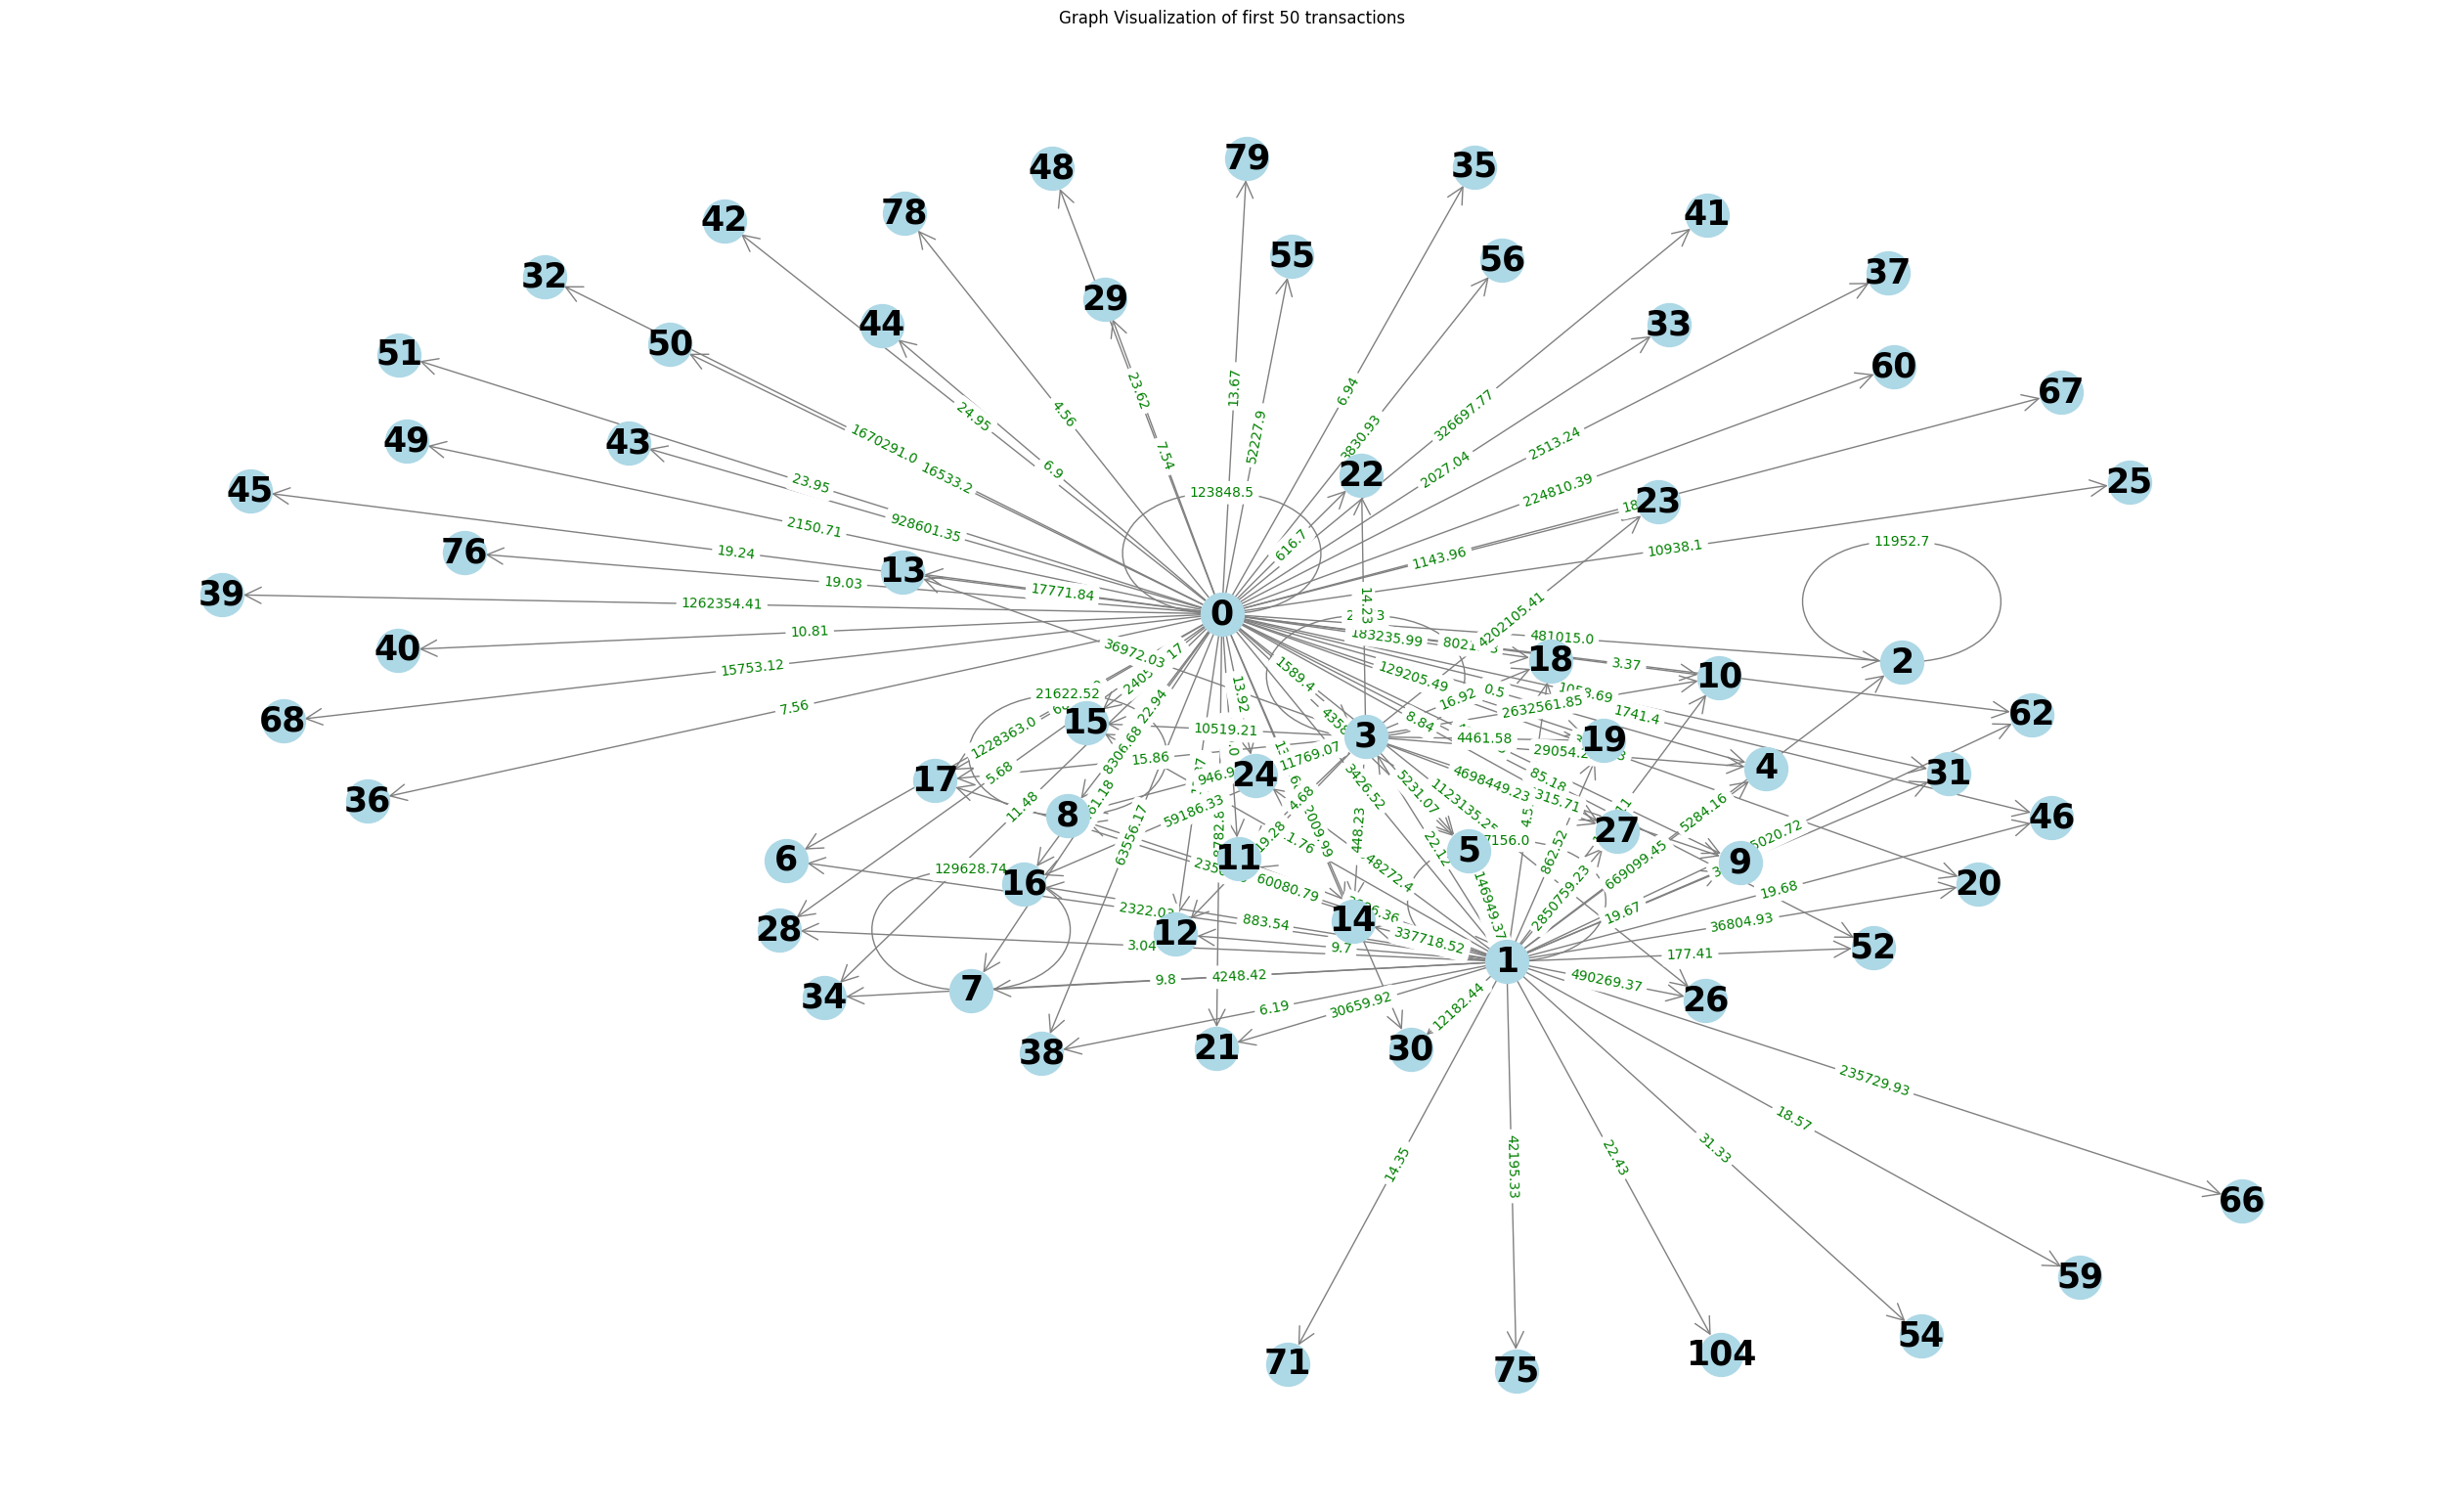

In [140]:
pos = nx.spring_layout(graph1) # shell, circular, spectral, spring, random, 

plt.figure(figsize=(25, 15))  # Increase figure size

nx.draw(
    graph1, 
    pos, 
    node_size=1000,  # Reduce node size for better visibility
    with_labels=True, 
    font_size=25, 
    font_weight='bold', 
    node_color='lightblue',  # Specify node color
    edge_color='gray',  # Specify edge color
    width=1,  # Adjust edge width
    arrows=True,  # Show arrows for directed edges
    arrowstyle='->',  # Specify arrow style
    arrowsize=30,  # Adjust arrow size
)

edge_labels = nx.get_edge_attributes(graph1, 'label')
nx.draw_networkx_edge_labels(
    graph1, 
    pos, 
    edge_labels=edge_labels, 
    label_pos=0.5,  # Adjust label position along edges
    font_size=10,  # Adjust font size
    font_color='green',  # Specify font color
)

plt.title('Graph Visualization of first 50 transactions')  # Add title to the plot
plt.axis('off')  # Hide axis
plt.show()

In [141]:
print(nx.degree_centrality(graph1)) # closeness_centrality, eigenvector_centrality, betweeness_centrality
print(nx.betweenness_centrality(graph1)) 

{0: 0.9393939393939394, 1: 0.5909090909090909, 2: 0.06060606060606061, 3: 0.33333333333333337, 4: 0.045454545454545456, 5: 0.045454545454545456, 6: 0.030303030303030304, 7: 0.06060606060606061, 8: 0.07575757575757576, 9: 0.045454545454545456, 10: 0.045454545454545456, 11: 0.045454545454545456, 12: 0.045454545454545456, 14: 0.045454545454545456, 13: 0.030303030303030304, 15: 0.045454545454545456, 16: 0.045454545454545456, 17: 0.045454545454545456, 18: 0.045454545454545456, 19: 0.045454545454545456, 20: 0.030303030303030304, 21: 0.030303030303030304, 22: 0.030303030303030304, 25: 0.015151515151515152, 26: 0.030303030303030304, 30: 0.030303030303030304, 34: 0.030303030303030304, 23: 0.030303030303030304, 28: 0.030303030303030304, 40: 0.015151515151515152, 46: 0.030303030303030304, 24: 0.045454545454545456, 31: 0.030303030303030304, 32: 0.015151515151515152, 37: 0.015151515151515152, 38: 0.030303030303030304, 39: 0.015151515151515152, 44: 0.015151515151515152, 45: 0.015151515151515152, 52:

In [ ]:
# TODO add edge and node features to graph --- https://www.youtube.com/watch?v=TlkpoB3JAHE&ab_channel=Koolac



## *** Questions: ****

##### - How specifically do I need to add features to the nodes and edges?
##### - Nodes are not added directly, assume I need to add them directly as well.
##### - Very inefficient node link mechanism --> took 10 seconds for 50 transactions --> 5 mil transactions will take me 277 hours... need to change method
##### - Is there a need to implement anything specific for a directed graph?
##### - going to the next step --> creating value for each relation, to be used in function
##### - Link prediction using node2vec???

In [ ]:
"""
NEXT 2 WEEKS:

1. Vectorize "BANKS" - BINs using binary encoding
2. Vectorize "Amount Paid"
3. Mapping through dictionary of all links --> No need to find individual links between accounts --> we are taking all accounts and the graph in general
4. Graph Visualization should include labels that are actual accounts
5. Add statistics to feature matrix X? --> if necessary
6. Apply graph on subset of 1000 transactions
7. Create Adjacency Matrix --> can be done through networkx or through existing links
8. Create GNN model
9. Write introduction
10. Write literature review

"""

In [ ]:
# What is node2vec?

# TODO BINs sould also be vectorized to avoid ordering
# TODO binary encoding for banks --> replace 300 features with 10 features that can represent a number in binary 
# TODO take random subset from transactions

# TODO calculating time --> circular definition for months (goes back to 0) --> sinus calculations --> same time different year cannot be distinguished in unix format
# TODO --> don't do yet.

# TODO payment amount --> separate based on power of 10s --> separate columns for thousands, hundreds etc.

# TODO no need to add nodes in order --> mapping thorugh dictionary is an option

# TODO potentially add statistics to feature matrix X


## SIMPLE GNN MODEL EXAMPLE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
num_features =
hidden_dim =
num_classes =
num_epochs =
features =
adj =
labels =

In [ ]:
class GCNBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNBlock, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x, adj):
        x = self.linear(x)
        x = torch.matmul(adj, x)
        x = F.relu(x)
        return x
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.gcn1 = GCNBlock(input_dim, hidden_dim)
        self.gcn2 = GCNBlock(hidden_dim, output_dim)
        
    def forward(self, x, adj):
        x = self.gcn1(x, adj)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gcn2(x, adj)
        return x
# Define the model
model = GCN(num_features, hidden_dim, num_classes)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# Train the model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(features, adj)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

In [19]:
import datetime
import os
from typing import Callable, Optional
import pandas as pd
from sklearn import preprocessing
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch

from torch_geometric.data import Data, InMemoryDataset

pd.set_option("display.max_columns", None)


class AMLtoGraph(InMemoryDataset):

    def __init__(
        self,
        root: str,
        edge_window_size: int = 10,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
    ):
        self.edge_window_size = edge_window_size
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self) -> str:
        return "HI-Small_Trans.csv"

    @property
    def processed_file_names(self) -> str:
        return "data.pt"

    @property
    def num_nodes(self) -> int:
        return self._data.edge_index.max().item() + 1

    def df_label_encoder(self, df, columns):
        le = preprocessing.LabelEncoder()
        for i in columns:
            df[i] = le.fit_transform(df[i].astype(str))
        return df

    def preprocess(self, df):
        df = self.df_label_encoder(
            df, ["Payment Format", "Payment Currency", "Receiving Currency"]
        )
        df["Timestamp"] = pd.to_datetime(df["Timestamp"])
        df["Timestamp"] = df["Timestamp"].apply(lambda x: x.value)
        df["Timestamp"] = (df["Timestamp"] - df["Timestamp"].min()) / (
            df["Timestamp"].max() - df["Timestamp"].min()
        )

        df["Account"] = df["From Bank"].astype(str) + "_" + df["Account"]
        df["Account.1"] = df["To Bank"].astype(str) + "_" + df["Account.1"]
        df = df.sort_values(by=["Account"])
        receiving_df = df[["Account.1", "Amount Received", "Receiving Currency"]]
        paying_df = df[["Account", "Amount Paid", "Payment Currency"]]
        receiving_df = receiving_df.rename({"Account.1": "Account"}, axis=1)
        currency_ls = sorted(df["Receiving Currency"].unique())

        return df, receiving_df, paying_df, currency_ls

    def get_all_account(self, df):
        ldf = df[["Account", "From Bank"]]
        rdf = df[["Account.1", "To Bank"]]
        suspicious = df[df["Is Laundering"] == 1]
        s1 = suspicious[["Account", "Is Laundering"]]
        s2 = suspicious[["Account.1", "Is Laundering"]]
        s2 = s2.rename({"Account.1": "Account"}, axis=1)
        suspicious = pd.concat([s1, s2], join="outer")
        suspicious = suspicious.drop_duplicates()

        ldf = ldf.rename({"From Bank": "Bank"}, axis=1)
        rdf = rdf.rename({"Account.1": "Account", "To Bank": "Bank"}, axis=1)
        df = pd.concat([ldf, rdf], join="outer")
        df = df.drop_duplicates()

        df["Is Laundering"] = 0
        df.set_index("Account", inplace=True)
        df.update(suspicious.set_index("Account"))
        df = df.reset_index()
        return df

    def paid_currency_aggregate(self, currency_ls, paying_df, accounts):
        for i in currency_ls:
            temp = paying_df[paying_df["Payment Currency"] == i]
            accounts["avg paid " + str(i)] = (
                temp["Amount Paid"].groupby(temp["Account"]).transform("mean")
            )
        return accounts

    def received_currency_aggregate(self, currency_ls, receiving_df, accounts):
        for i in currency_ls:
            temp = receiving_df[receiving_df["Receiving Currency"] == i]
            accounts["avg received " + str(i)] = (
                temp["Amount Received"].groupby(temp["Account"]).transform("mean")
            )
        accounts = accounts.fillna(0)
        return accounts

    def get_edge_df(self, accounts, df):
        accounts = accounts.reset_index(drop=True)
        accounts["ID"] = accounts.index
        mapping_dict = dict(zip(accounts["Account"], accounts["ID"]))
        df["From"] = df["Account"].map(mapping_dict)
        df["To"] = df["Account.1"].map(mapping_dict)
        df = df.drop(["Account", "Account.1", "From Bank", "To Bank", "Payment Format", "Payment Currency"], axis=1)

        edge_index = torch.stack(
            [torch.from_numpy(df["From"].values), torch.from_numpy(df["To"].values)],
            dim=0,
        )

        df = df.drop(["Is Laundering", "From", "To"], axis=1)

        edge_attr = torch.from_numpy(df.values).to(torch.float)
        return edge_attr, edge_index

    def get_node_attr(self, currency_ls, paying_df, receiving_df, accounts):
        node_df = self.paid_currency_aggregate(currency_ls, paying_df, accounts)
        node_df = self.received_currency_aggregate(currency_ls, receiving_df, node_df)
        node_label = torch.from_numpy(node_df["Is Laundering"].values).to(torch.float)
        node_df = node_df.drop(["Account", "Is Laundering"], axis=1)
        node_df = self.df_label_encoder(node_df, ["Bank"])
        node_df = torch.from_numpy(node_df.values).to(torch.float)
        return node_df, node_label

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
dataset = AMLtoGraph("/Users/owhy/Downloads")
print(type(dataset))

<class '__main__.AMLtoGraph'>


In [ ]:
dataset[0]

Data(x=[515088, 31], edge_index=[2, 5078345], edge_attr=[5078345, 6], y=[515088])

In [ ]:
print("Node features shape:", example.x.shape)
print("Edge index shape:", example.edge_index.shape)
print("Edge attributes shape:", example.edge_attr.shape)
print("Labels shape:", example.y.shape)

Node features shape: torch.Size([515088, 31])
Edge index shape: torch.Size([2, 5078345])
Edge attributes shape: torch.Size([5078345, 6])
Labels shape: torch.Size([515088])


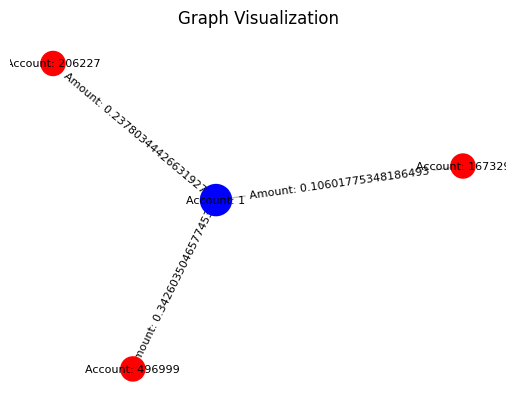

In [ ]:
# Convert the PyTorch Geometric Data object to a NetworkX graph
def to_networkx(data, node_id, num_transactions=10):
    G = nx.Graph()

    # Add the central node
    G.add_node(node_id, label=f"Account: {node_id}", color="blue", size=500)

    # Get the indices of transactions related to the given node
    related_edges = (data.edge_index[0] == node_id).nonzero().squeeze()
    num_related_edges = min(num_transactions, related_edges.numel())

    # Add the related transactions and corresponding nodes
    for i in range(num_related_edges):
        transaction_id = related_edges[i].item()
        source_node_id = data.edge_index[0, transaction_id].item()
        target_node_id = data.edge_index[1, transaction_id].item()
        transaction_amount = data.edge_attr[transaction_id, 0].item()

        # Add the transaction edge
        G.add_edge(
            source_node_id,
            target_node_id,
            label=f"Amount: {transaction_amount}",
            color="gray",
        )

        # Add the source and target nodes
        if source_node_id != node_id:
            G.add_node(
                source_node_id,
                label=f"Account: {source_node_id}",
                color="green",
                size=300,
            )
        if target_node_id != node_id:
            G.add_node(
                target_node_id,
                label=f"Account: {target_node_id}",
                color="red",
                size=300,
            )

    return G


# Visualize the NetworkX graph
def visualize_networkx(graph):
    pos = nx.spring_layout(graph, seed=42)  # Compute layout

    # Draw nodes
    node_colors = [graph.nodes[n]["color"] for n in graph.nodes()]
    node_sizes = [graph.nodes[n]["size"] for n in graph.nodes()]
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=node_sizes)

    # Draw edges
    edge_colors = [graph.edges[e]["color"] for e in graph.edges()]
    nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.5, edge_color=edge_colors)

    # Draw labels
    node_labels = nx.get_node_attributes(graph, "label")
    nx.draw_networkx_labels(
        graph, pos, labels=node_labels, font_size=8, font_color="black"
    )
    edge_labels = nx.get_edge_attributes(graph, "label")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

    # Display the graph
    plt.title("Graph Visualization")
    plt.axis("off")
    plt.show()


# Convert the first example in the dataset to a NetworkX graph focused on a specific node
example_index = 0
example_data = dataset[example_index]
node_id_to_visualize = 1  # ID of the node to visualize
num_transactions_to_visualize = 10  # Number of transactions to visualize
graph = to_networkx(example_data, node_id_to_visualize, num_transactions_to_visualize)

# Visualize the NetworkX graph
visualize_networkx(graph)